# Test the one-line CLEDB inversion on synthetic CLE data.

In [1]:
## the script version "test_1line.py" is generated by exporting this notebook via file -> export as -> executable script.
## Do not directly edit that version!

<Figure size 1080x1080 with 0 Axes>

In [2]:
## Needed modules
import pickle                ## CLE synthetic observation data cube is saved in the pickle format.
import importlib             ## reloads imports (python default settings will not reload small changes).

from numba.typed import List ## Most numba functions are loaded by the CLEDB modules; non-reflected lists are needed to create a list of 2 bservation arrays

## Inversion Constants and control parameter imports.
## symbolic links pointing to the root directory containing the files are used. Pythondoes not allow relative upstream references anymore
import constants as consts
import ctrlparams 
params=ctrlparams.ctrlparams()    ## just a shorter label

### 1. LOAD the input data

In [3]:
## observations of a 3 dipole coronal structure of a Fe XIII combined observation
## sobs1-3 are the independent dipoles
## sobsa is the combined 3 dipole output
## waveA and waveB are the wavelength arrays for the two Fe XIII lines

with open('obsstokes_3dipole_hires_fullspectra.pkl','rb') as f:
    sobs1,sobs2,sobs3,sobsa,waveA,waveB = pickle.load(f)  
### reversing of the wavelength range. THIS IS NEEDED! CLE writes frequency-wise, so wavelengths are reversed in the original datacubes!!!!!!
sobs1=sobs1[:,:,::-1,:]   
sobs2=sobs2[:,:,::-1,:]
sobs3=sobs3[:,:,::-1,:]
sobsa=sobsa[:,:,::-1,:]
waveA=waveA[::-1]
waveB=waveB[::-1]
## we test here using sobs1.

In [4]:
## load the fake observation muram data.
## FE XIII 1074+1079
## sobs_a is normalized to first column (stokes I 1074)
## RMS is 1 in this example; observation can be convoluted with noise if needed and re-normalized again

# with open('obsstokes_avg_muram.pkl','rb') as f:
#     f1aa,f2aa,sobs_a,yobs_a,rms,wvl,xxl,yyl = pickle.load(f)    

# with open('obsstokes_avg_muram2.pkl','rb') as f:
#     sobs_a,yobs_a,rms,xxl,yyl = pickle.load(f)        

### 2. Test the CLEDB_PREPINV module with synthetic data. 

##### Remember to set your personal options and database paths in the ctrlparams class (in the parent directory) before continuing.

In [5]:
import CLEDB_PREPINV.CLEDB_PREPINV as prepinv  ##imports from the CLEDB_PREPINV subdirectory

In [6]:
## take in just one line from the observation; e.g. one set of IQUV

## arrange the two observation "files" in a simple list;
## un-necesary step given the shape of sobs array, but it mimicks a file/header structure.

## set a proper numba typed list
sobs_lst=[sobsa[:,:,:,0:4]]                   ## standard python lists will be deprecated by numba
sobs_in = List()                              ## this is the List object implemented by numba; It utilizes memory in a column-like fashion.
[sobs_in.append(x) for x in sobs_lst]         ## Numba developers claim that it is a significantly faster performing object

[None]

##### preprocess the observation "files"

In [7]:
importlib.reload(prepinv)       ## If module is modified, reload the contents
sobs_tot,yobs,rms,background,keyvals,sobs_totrot,aobs=prepinv.sobs_preprocess(sobs_in,params)

##### At this point all necesary data is loaded into memory; 
##### An analythical LOS B field solution is used and the database is not required in this case

### 3. Test the CLEDB_PROC module with the same synthetic data.

In [8]:
import CLEDB_PROC.CLEDB_PROC as procinv

##### Process the spectroscopy outputs

In [9]:
#importlib.reload(procinv)       ## If module is modified, reload the contents 
specout=procinv.spectro_proc(sobs_in,sobs_tot,rms,background,keyvals,consts,params)

In [9]:
##### Process the LOS vector magnetic field inversion products (Analythical solution)

In [10]:
importlib.reload(procinv)       ## If module is modified, reload the contents 
blosout=procinv.blos_proc(sobs_tot,rms,keyvals,consts,params)

<ipython-input-10-9d66df0eb8c1>:2: RuntimeWarning: invalid value encountered in double_scalars
  blosout=procinv.blos_proc(sobs_tot,rms,keyvals,consts,params)


### 4. DUMP results (optional)

In [8]:
from datetime import datetime
datestamp = datetime.now().strftime("%Y%m%d-%H:%M:%S")

with open(f'outparams_1line_{datestamp}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([specout,blosout], f)

##### All should be good if we reached this point; all the outputs should be computed and saved.

### 5. PLOT the outputs (optional)

In [11]:
##needed libraries and functions
from matplotlib import pyplot as plt
# %matplotlib widget                    ##interactive plotting;use only on local machines if available

# colorbar function to have nice colorbars in figures
def colorbar(mappable):
   from mpl_toolkits.axes_grid1 import make_axes_locatable
   import matplotlib.pyplot as plt
   last_axes = plt.gca()
   ax = mappable.axes
   fig = ax.figure
   divider = make_axes_locatable(ax)
   cax = divider.append_axes("right", size="3.5%", pad=0.05)
   cbar = fig.colorbar(mappable, cax=cax)
   #cbar.formatter.set_powerlimits((0,4))
   plt.sca(last_axes)
   return cbar

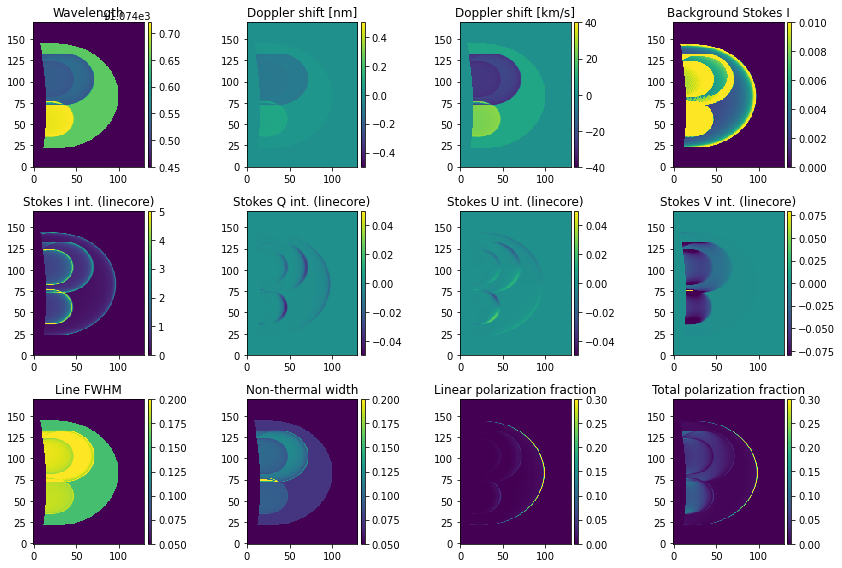

In [12]:
## Plot spectroscopy

linen=0                ## choose which line to plot; range is [0:1] for 2 line input

fig, plots = plt.subplots(nrows=3, ncols=4, figsize=(12,8))
ab=plots[0,0].imshow(specout[230:400,65:195,linen,0],vmin=1074.45,vmax=1074.72)
plots[0,0].set_title('Wavelength')
colorbar(ab)

ab=plots[0,1].imshow(specout[230:400,65:195,linen,1],vmin=-0.5,vmax=0.5)
plots[0,1].set_title('Doppler shift [nm]')
colorbar(ab)

ab=plots[0,2].imshow(specout[230:400,65:195,linen,2],vmin=-40,vmax=40)
plots[0,2].set_title('Doppler shift [km/s]')
colorbar(ab)

ab=plots[0,3].imshow(specout[230:400,65:195,linen,7],vmin=0,vmax=0.01)
plots[0,3].set_title('Background Stokes I')
colorbar(ab)


ab=plots[1,0].imshow(specout[230:400,65:195,linen,3],vmin=0,vmax=5)
plots[1,0].set_title('Stokes I int. (linecore)')
colorbar(ab)

ab=plots[1,1].imshow(specout[230:400,65:195,linen,4],vmin=-0.05,vmax=0.05)
plots[1,1].set_title('Stokes Q int. (linecore)')
colorbar(ab)

ab=plots[1,2].imshow(specout[230:400,65:195,linen,5],vmin=-0.05,vmax=0.05)
plots[1,2].set_title('Stokes U int. (linecore)')
colorbar(ab)

ab=plots[1,3].imshow(specout[230:400,65:195,linen,6],vmin=-0.08,vmax=0.08)
plots[1,3].set_title('Stokes V int. (linecore)')
colorbar(ab)



ab=plots[2,0].imshow(specout[230:400,65:195,linen,8],vmin=0.05,vmax=0.2)
plots[2,0].set_title('Line FWHM')
colorbar(ab)

ab=plots[2,1].imshow(specout[230:400,65:195,linen,9],vmin=0.05,vmax=0.2)
plots[2,1].set_title('Non-thermal width')
colorbar(ab)

ab=plots[2,2].imshow(specout[230:400,65:195,linen,10],vmin=0.0,vmax=0.3)
plots[2,2].set_title('Linear polarization fraction')
colorbar(ab)

ab=plots[2,3].imshow(specout[230:400,65:195,linen,11],vmin=0.0,vmax=0.3)
plots[2,3].set_title('Total polarization fraction')
colorbar(ab)
plt.tight_layout()

plt.savefig(f"specout_1line_{datestamp}.pdf")

/home/alin/anaconda3/envs/CLEDBenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


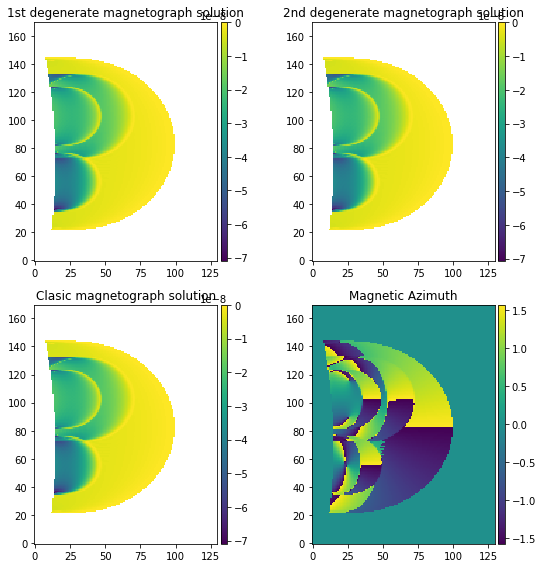

In [13]:
## plot 1-line BLOS


fig, plots = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
ab=plots[0,0].imshow(blosout[230:400,65:195,0])
plots[0,0].set_title('1st degenerate magnetograph solution')
colorbar(ab)

ab=plots[0,1].imshow(blosout[230:400,65:195,1])
plots[0,1].set_title('2nd degenerate magnetograph solution')
colorbar(ab)

ab=plots[1,0].imshow(blosout[230:400,65:195,2])
plots[1,0].set_title('Clasic magnetograph solution')
colorbar(ab)

ab=plots[1,1].imshow(blosout[230:400,65:195,3])
plots[1,1].set_title('Magnetic Azimuth')
colorbar(ab)
plt.tight_layout()

plt.savefig(f"blosout_1line_{datestamp}.pdf")